In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
# folder_path = 'drive/MyDrive/i/brahma_kamal'
# for filename in os.listdir(folder_path):
#     if "(" in filename or ")" in filename:
#         new_name = filename.replace(" (","").replace(")","")

#         old_file = os.path.join(folder_path,filename)
#         new_file = os.path.join(folder_path,new_name)
#         os.rename(old_file,new_file)
#         print(f"Renamed {filename} to {new_name}")

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
folder_path = 'drive/MyDrive/i'

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# CONFIGURATION
BATCH_SIZE = 32
IMG_SIZE = (224, 224) # Standard size for MobileNet/ResNet
dataset_dir = "drive/MyDrive/i" # Path to your folder

# Use mixed precision for faster training on GPUs (Industry standard)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [6]:
# Load Training Data (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load Validation Data (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print(f"Detected Classes: {class_names}")

# PERFORMANCE OPTIMIZATION (Prefetching)
# This prevents I/O blocking. The GPU won't wait for data loading.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1044 files belonging to 7 classes.
Using 836 files for training.
Found 1044 files belonging to 7 classes.
Using 208 files for validation.
Detected Classes: ['dahlia', 'hibiscuss', 'lotus', 'marigold', 'rose', 'sunflower', 'waterlily']


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ]
)

In [8]:
# 1. Base Model: Download weights but exclude the top classification layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model so we don't destroy pre-trained patterns initially
base_model.trainable = False

# 3. Create the final model architecture
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)  # Apply augmentation first

# Pre-processing specific to MobileNetV2 (scales pixels to -1 to 1)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False) # Run through base model
x = layers.GlobalAveragePooling2D()(x) # Condense features
x = layers.Dropout(0.2)(x) # Regularization to prevent overfitting

# Final Output Layer (7 neurons for 7 species)
outputs = layers.Dense(7, activation='softmax', dtype='float32')(x)

model = keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# CALLBACKS
callbacks = [
    # Stop training if validation loss doesn't improve for 5 epochs
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    # Save the best version of the model automatically
    keras.callbacks.ModelCheckpoint("best_species_model.keras", save_best_only=True)
]

In [10]:
history = model.fit(
    train_ds,
    epochs=20, # Set high, EarlyStopping will cut it short if needed
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.4031 - loss: 1.6741 - val_accuracy: 0.8654 - val_loss: 0.6755
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8263 - loss: 0.6300 - val_accuracy: 0.9231 - val_loss: 0.3658
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8939 - loss: 0.3959 - val_accuracy: 0.9615 - val_loss: 0.2664
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9311 - loss: 0.2836 - val_accuracy: 0.9567 - val_loss: 0.2351
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9544 - loss: 0.2216 - val_accuracy: 0.9615 - val_loss: 0.1965
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9470 - loss: 0.1797 - val_accuracy: 0.9712 - val_loss: 0.1861
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9509 - loss: 0.1760 - val_accuracy: 0.9375 - val_loss: 0.1966
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9622 - loss: 0.1811 - val_accuracy: 0.9712 - v

In [11]:
# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the last 20 (optional tuning)
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with a much lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # 100x smaller learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again
history_fine = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 286ms/step - accuracy: 0.8399 - loss: 0.4924 - val_accuracy: 0.9712 - val_loss: 0.0910
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9219 - loss: 0.2675 - val_accuracy: 0.9712 - val_loss: 0.0848
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9319 - loss: 0.2037 - val_accuracy: 0.9712 - val_loss: 0.0823
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9402 - loss: 0.2196 - val_accuracy: 0.9712 - val_loss: 0.0809
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9535 - loss: 0.1646 - val_accuracy: 0.9712 - val_loss: 0.0783
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9620 - loss: 0.1339 - val_accuracy: 0.9712 - val_loss: 0.0765
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9636 - loss: 0.1176 - val_accuracy: 0.9760 - val_loss: 0.0746
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9762 - loss: 0.1049 - val_accuracy: 0.976

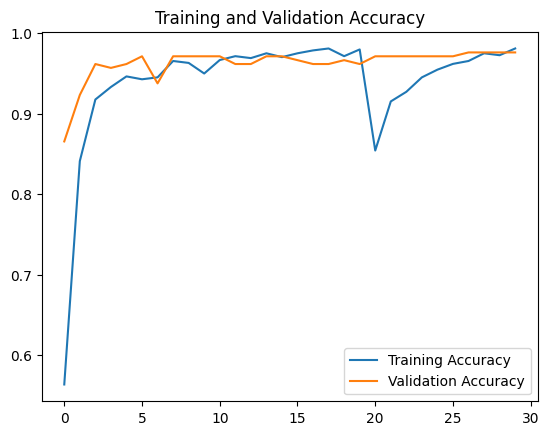

In [12]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [13]:
def predict_species(image_path):
    img = keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

# Example usage
# predict_species("downloaded_test_image.jpg")

In [16]:
predict_species("pool.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
This image most likely belongs to marigold with a 26.18 percent confidence.


In [18]:
predict_species("p.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
This image most likely belongs to sunflower with a 31.18 percent confidence.


In [17]:
predict_species("/content/rose (5).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This image most likely belongs to rose with a 25.18 percent confidence.


In [19]:
predict_species("ro.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
This image most likely belongs to rose with a 28.15 percent confidence.


In [20]:
predict_species("d.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
This image most likely belongs to dahlia with a 20.77 percent confidence.


In [21]:
model.save('drive/MyDrive/flower_species_model.keras')

The model has been saved to your Google Drive as `flower_species_model.keras`.